# MBML: Statlog (German Credit Data) Data Set

## 0. Install AIF360

Install AIF360 before running this notebook. It's best to create an environment to work in first. From the command line:
```
conda create --name aif360 python=3.7
```
Then activate the environment:
```
conda activate aif360
```
Install the complete AIF360 library:
```
pip install 'aif360[all]'
```
Now open this notebook:
```
jupyter notebook mbml_german.ipynb
```

## 1. Import libraries

The post [Jake VanderPlas, Installing Python Packages from a Jupyter Notebook (2017)](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/) might be helpful if you don't have all the packages you need in the imports below.

In [1]:
import sys

import os.path
from os import path

import requests

import math
import random
import numpy as np
import pandas as pd
import scipy.stats as ss

from aif360.datasets import StructuredDataset
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

#!{sys.executable} -m pip install xgboost
#!brew install libomp
#import xgboost as xgb
#from xgboost import XGBClassifier

#!{sys.executable} -m pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({
    "text.usetex": True})

## 2. Download and read file

- Go to the [website for the Statlog (German Credit Data) Data Set](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) and familiarise yourself with the data.
- Note that the information states that the following cost matrix should be used:
```
                      actual class
                     | good | bad |
                     |  1   |  2  |
predicted | good |1|  0   |  5  |
class     |  bad |2|  1   |  0  |
```
- Thus only errors contribute to the cost in training and a false positive costs five times that of a false negative.

In [2]:
def download_data(url, file):
    if path.exists(file):
        with open(file, 'wb') as f:
            f.write(requests.get(url).content)

names = ['checking', 'loanterm', 'credithistory', 'loanpurpose', 'loanamount', 
         'savings', 'employmenttime', 'repayrate', 'personalsex', 'otherdebtors', 
         'residencetime', 'propertystatus', 'age', 'otherloans', 'housing', 
         'ncredits', 'job', 'ndependents', 'telephone', 'foreignworker', 'goodcredit']

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
file = '../aif360/data/raw/german/german.data'
download_data(url, file)
data = pd.read_csv(file, names = names, delimiter=' ')

## 3. Exploratory data analysis

In [3]:
print('shape:', data.shape)
print('missing values:', data.isnull().values.any())
print('unique feature rows:', len(data.drop_duplicates(subset=names[:-1])))

shape: (1000, 21)
missing values: False
unique feature rows: 1000


In [4]:
def check_dtypes(data_df):
    """Output data types in the dataframe and for categorical data types obeject show all the unique values"""
    data_num = list(data_df.select_dtypes(exclude='object'))
    data_cat = list(data_df.select_dtypes(include='object'))

    print('numeric data:\n')
    print(data_df[data_num].dtypes)
    print('\nCategorical Types\n')
    cat_dict = {feat : data_df[feat].unique() for feat in list(data_cat)}
    for k, v in cat_dict.items():
        print(k, v)
    return data_num, cat_dict

#cols_numeric, cat_dict = check_dtypes(data)
#cols_cat = list(cat_dict.keys())

data.goodcredit.replace([1,2], [1,0], inplace=True)
data.telephone.replace(['A192','A191'], [1,0], inplace=True)
data.foreignworker.replace(['A201','A202'], [1,0], inplace=True)

data.personalsex.replace(['A91', 'A92', 'A93', 'A94', 'A95'], [1,0,1,1,0], inplace=True)
data = data.rename(columns={'personalsex': 'male'})

display(data.describe())

cols_numeric, cat_dict = check_dtypes(data)
cols_categorical = list(cat_dict.keys())

,loanterm,loanamount,repayrate,male,residencetime,age,ncredits,ndependents,telephone,foreignworker,goodcredit
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,0.690000,2.845000,35.546000,1.407000,1.155000,0.404000,0.963000,0.700000
std,12.058814,2822.736876,1.118715,0.462725,1.103718,11.375469,0.577654,0.362086,0.490943,0.188856,0.458487
min,4.000000,250.000000,1.000000,0.000000,1.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,12.000000,1365.500000,2.000000,0.000000,2.000000,27.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,1.000000,3.000000,33.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,1.000000,4.000000,42.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,1.000000,4.000000,75.000000,4.000000,2.000000,1.000000,1.000000,1.000000


numeric data:

loanterm         int64
loanamount       int64
repayrate        int64
male             int64
residencetime    int64
age              int64
ncredits         int64
ndependents      int64
telephone        int64
foreignworker    int64
goodcredit       int64
dtype: object

Categorical Types

checking ['A11' 'A12' 'A14' 'A13']
credithistory ['A34' 'A32' 'A33' 'A30' 'A31']
loanpurpose ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
savings ['A65' 'A61' 'A63' 'A64' 'A62']
employmenttime ['A75' 'A73' 'A74' 'A71' 'A72']
otherdebtors ['A101' 'A103' 'A102']
propertystatus ['A121' 'A122' 'A124' 'A123']
otherloans ['A143' 'A141' 'A142']
housing ['A152' 'A153' 'A151']
job ['A173' 'A172' 'A174' 'A171']


### 3.1 Comments

- 70% of the population are good credit risks
- 69% of the population is male
- 97% of the population are foreignworkers
- Many of the numerical. data types are not really continuous variables but rather discrete because they are rounded and take only a few values.
- The continuous variables are ```[loanterm, loanamount, age]```
- ```ndependents``` takes only 2 values in the data, 1 or 2
- ```[ncredits, residencetime, repayrate``` all take integer values between 1 and 4

### 3.2 Look for associations in the data

We try a few measures of association:
- [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
- [Normalised mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants)
- [Cramers V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)
- [Proficiency](https://en.wikipedia.org/wiki/Uncertainty_coefficient)
- [correlation ratio](https://en.wikipedia.org/wiki/Correlation_ratio)

Some helpful stuff here: [Shaked Zychlinski
, The Search for Categorical Correlation (2018)](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)

In [5]:
cols_cont = ['loanterm', 'loanamount', 'age']
cols_disc = ['checking', 'credithistory', 'loanpurpose',
             'savings', 'employmenttime', 'repayrate', 'male', 'otherdebtors', 
             'residencetime', 'propertystatus', 'otherloans', 'housing', 
             'ncredits', 'job', 'ndependents', 'telephone', 'foreignworker', 'goodcredit']

def normalised_mutual_information(x, y):
    """mutual information between x and y"""
    p_x = x.value_counts(normalize=True)
    p_y = y.value_counts(normalize=True)
    p_xy = pd.Series(zip(x,y)).value_counts(normalize=True)
    norm = math.sqrt( ss.entropy(p_x) * ss.entropy(p_y)  )
    return sum([p * math.log(p / (p_x[xy[0]] * p_y[xy[1]])) for xy, p in p_xy.items()]) / norm

def cramers_v(x, y):
    contingency_table = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(contingency_table)[0]
    n = len(x)
    phi2 = chi2 / n
    r, k = contingency_table.shape
    # Correct for bias
    phi2 = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r = r - (r-1)**2 / (n-1)
    k = k - (k-1)**2 / (n-1)
    return np.sqrt(phi2 / min((k-1),(r-1)))

def conditional_entropy(x, y):
    """entropy of y | x"""
    p_x = x.value_counts(normalize=True)
    p_xy = pd.Series(zip(x,y)).value_counts(normalize=True)
    return sum([p * math.log(p_x[xy[0]]/p) for  xy, p in p_xy.items()])

def proficiency(x, y):
    """proficiency of y | x"""
    ey = ss.entropy(y.value_counts(normalize=True))
    return (ey - conditional_entropy(x, y)) / ey

def correlation_ratio(df, cat_col, y_col):
    """The weighted variance of the category means divided by the variance of all samples"""
    y_mean = df[y_col].mean()
    gb = df[[cat_col, y_col]].groupby(cat_col)
    cat_means = gb.mean()
    cat_nums = gb.count()
    return math.sqrt( (cat_nums*(cat_means-y_mean)**2).sum() / ((df[y_col]-y_mean)**2).sum() )

test_df = pd.DataFrame({'subject':['a', 'a', 'a', 'a', 'a', 
                                   'b', 'b', 'b', 'b', 
                                   'c', 'c', 'c', 'c', 'c', 'c'],
                        'score':[45, 70 ,29, 15, 21,
                                 40, 20, 30, 42,
                                 65, 95, 80, 70, 85, 73]})
print(correlation_ratio(test_df, 'subject', 'score'), math.sqrt(678/964))

0.8386414621724166 0.8386414621724166


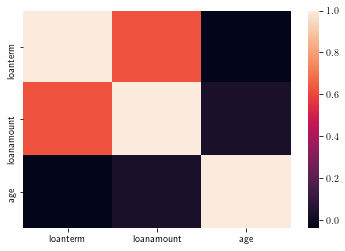

In [6]:
ax = sns.heatmap(data[cols_cont].corr())

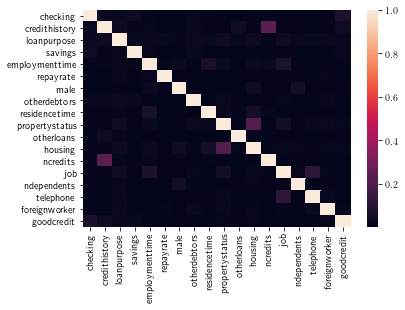

In [7]:
mi = pd.DataFrame([[normalised_mutual_information(data[x], data[y]) for x in cols_disc] for y in cols_disc],
                  index = cols_disc, columns = cols_disc)
ax = sns.heatmap(mi)

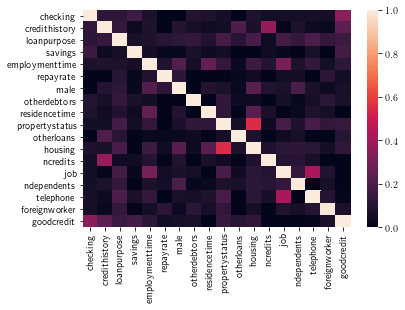

In [8]:
cv = pd.DataFrame([[cramers_v(data[x], data[y]) for x in cols_disc] for y in cols_disc],
                  index = cols_disc, columns = cols_disc)
ax = sns.heatmap(cv)

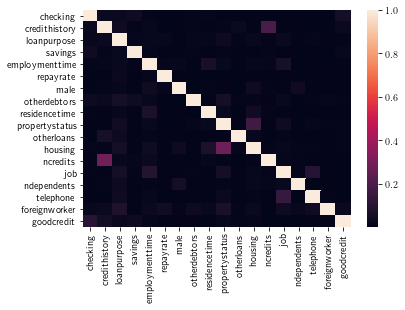

In [9]:
prof = pd.DataFrame([[proficiency(data[x], data[y]) for x in cols_disc] for y in cols_disc],
                    index = cols_disc, columns = cols_disc)
ax = sns.heatmap(prof)

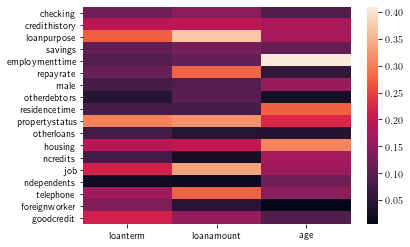

In [10]:
cr = pd.DataFrame([[correlation_ratio(data, cat, num) for num in cols_cont] for cat in cols_disc],
                    index = cols_disc, columns = cols_cont)
ax = sns.heatmap(cr)

### 3.3 Pairwise distributions for continuous variables

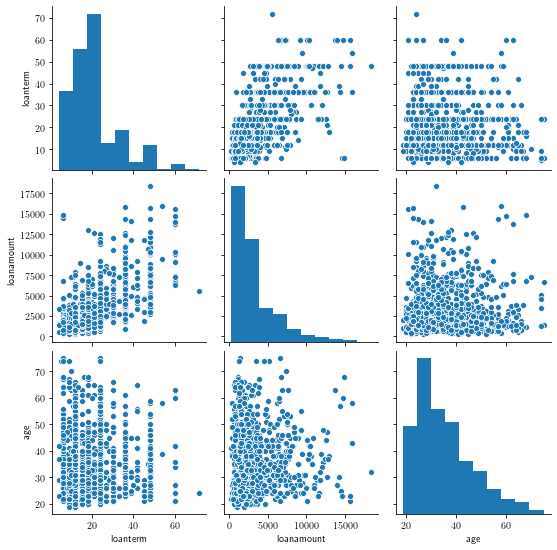

In [11]:
ax = sns.pairplot(data[cols_cont])

- Not surprising that loan amount and loan term are positively correlated

### 3.4 Compare distributions of features for different values of the target variable (good and bad credit risks)

First we rename some feature categories so we can read our plots more easily.

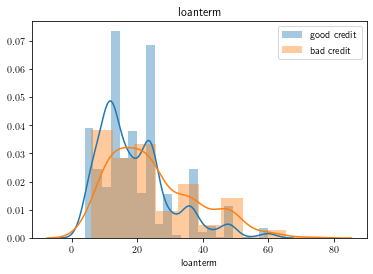

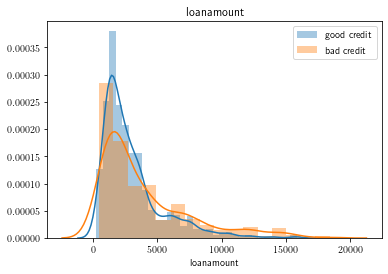

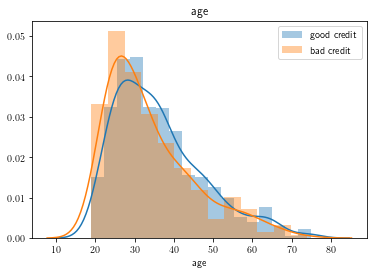

In [12]:
temp_data = data.copy()
temp_data.checking.replace(['A11', 'A12', 'A13', 'A14'],
                           ['-ve', '<200', '>200', 'none'], inplace=True)
temp_data.credithistory.replace(['A30', 'A31', 'A32', 'A33', 'A34'],
                              ['none', 'paid', 'on-time', 'late', 'critical'], inplace=True)
temp_data.loanpurpose.replace(['A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A48', 'A49', 'A410'],
                              ['newcar', 'oldcar', 'furniture', 'tv', 'appliance', 'repair',
                               'edu', 'train', 'buss', 'other'], inplace=True)
temp_data.savings.replace(['A61', 'A62', 'A63', 'A64', 'A65'],
                          ['<100', '<500', '<1000', '>1000', 'none'], inplace=True)
temp_data.employmenttime.replace(['A71', 'A72', 'A73', 'A74', 'A75'],
                                 ['0', '<1', '<4', '<7', '>7'], inplace=True)
#temp_data.personalsex.replace(['A91', 'A92', 'A93', 'A94'],
#                              ['mdiv', 'fdivmar', 'msin', 'mmarwid'], inplace=True)
temp_data.otherdebtors.replace(['A101', 'A102', 'A103'],
                               ['none', 'joint', 'guar'], inplace=True)
temp_data.propertystatus.replace(['A121', 'A122', 'A123', 'A124'],
                                 ['property', 'savings', 'car', 'none'], inplace=True)
temp_data.otherloans.replace(['A141', 'A142', 'A143'],
                             ['bank', 'store', 'none'], inplace=True)
temp_data.housing.replace(['A151', 'A152', 'A153'],
                          ['rent', 'own', 'free'], inplace=True)
temp_data.job.replace(['A171', 'A172', 'A173', 'A174'],
                      ['none', 'unskilled', 'skilled', 'manager'], inplace=True)

accept = temp_data[data['goodcredit']==1]
reject = temp_data[data['goodcredit']==0]

def compare_distributions_continuous(accept, reject, var_name, accept_label, reject_label):
    ax = sns.distplot(accept[var_name], label=accept_label)
    ax = sns.distplot(reject[var_name], label=reject_label)
    ax.set_title(var_name)
    plt.legend()
    plt.show()
    
for col in cols_cont:
    compare_distributions_continuous(accept, reject, col, 'good credit', 'bad credit')

### 3.5 Comments

- We see the kinds of spikes we might reasonably expect for loan terms at 3, 6 and 12 month intervals
- Loan amount distributions has fatter tails for bad credit risk (there are more very small or very large loan amounts)
- Good credit risks are older

In [13]:
data = data.rename(columns={'age': 'age>=30'})
data['age>=30'] = data['age>=30']>=30
data['age>=30']=data['age>=30'].astype(int)

cols_cont = ['loanterm', 'loanamount']
cols_disc = ['checking', 'credithistory', 'loanpurpose',
             'savings', 'employmenttime', 'repayrate', 'male', 'otherdebtors', 
             'residencetime', 'age>=30', 'propertystatus', 'otherloans', 'housing', 
             'ncredits', 'job', 'ndependents', 'telephone', 'foreignworker', 'goodcredit']

temp_data = temp_data.rename(columns={'age': 'age>=30'})
temp_data['age>=30'] = data['age>=30']

accept = temp_data[data['goodcredit']==1]
reject = temp_data[data['goodcredit']==0]

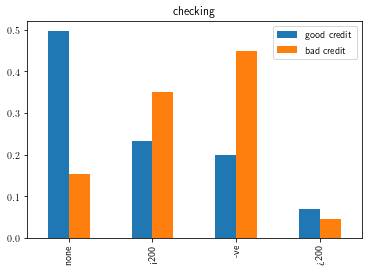

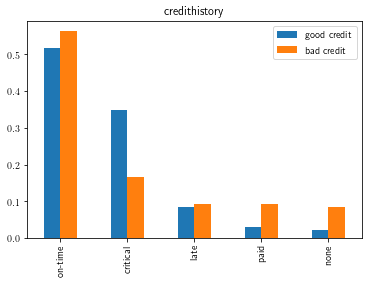

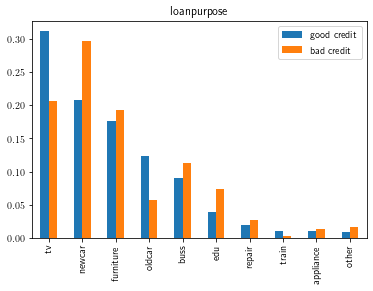

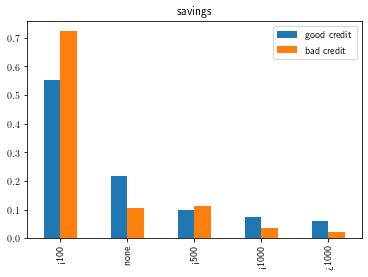

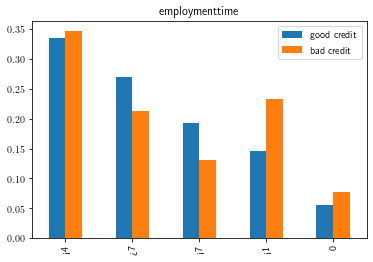

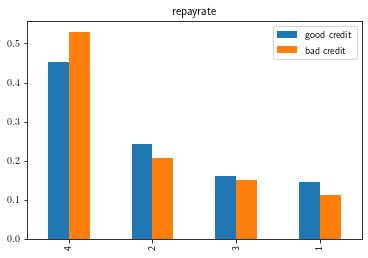

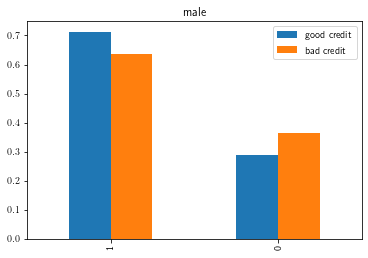

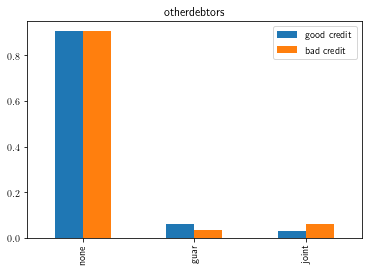

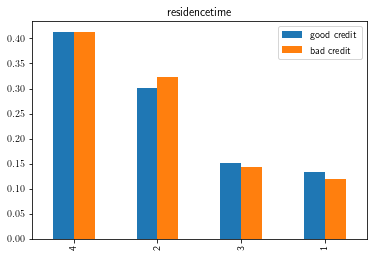

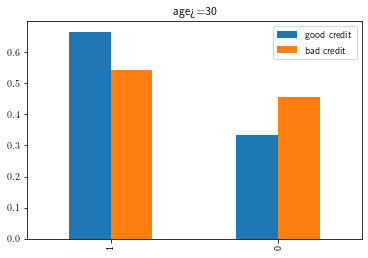

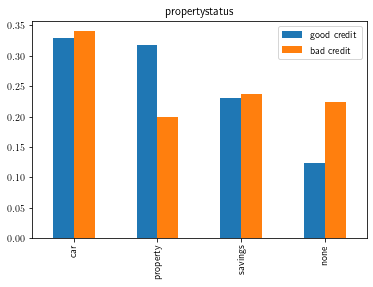

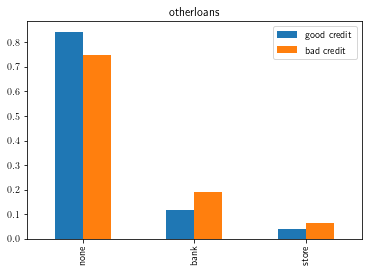

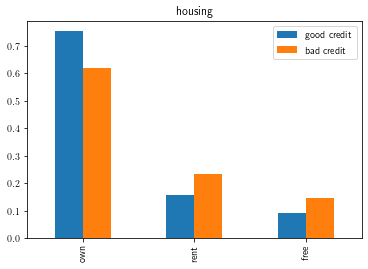

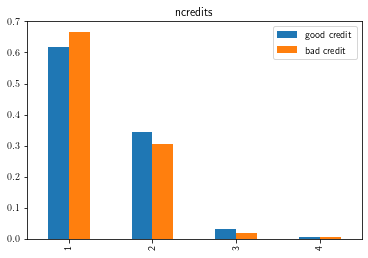

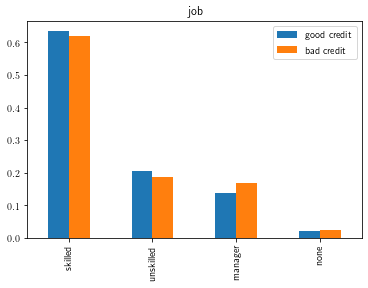

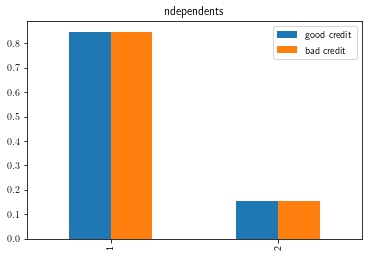

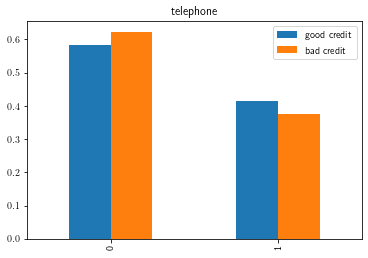

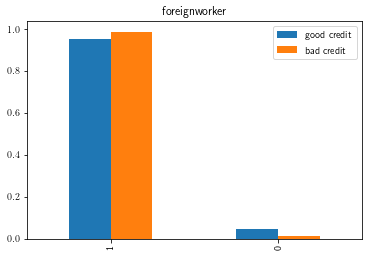

In [14]:
def compare_distributions_discrete(accept, reject, var_name, accept_label, reject_label, normalize):
    dist_df = pd.concat([pd.Series(accept[var_name].value_counts(normalize=normalize), name=accept_label),
                         pd.Series(reject[var_name].value_counts(normalize=normalize), name=reject_label )],
                        axis=1)
    ax = dist_df.plot.bar()
    ax.set_title(var_name)

for col in cols_disc[:-1]:
    compare_distributions_discrete(accept, reject, col, 'good credit', 'bad credit', True)

### 3.6 Comments

- ```checking``` 'no checking account' is good
- ```credithistory``` 'critical account/ other credits existing (not at this bank)' in credit history seems to be good
- ```loanpurpose```
  - buying a tv is good but other appliances not so much
  - old car better than new
- ```savings``` having savings is good
- ```employmenttime``` having worked for longer is better
- ```repayrate``` repaying instalments that are a smaller proportion of your disposable income is better
- ```personalsex``` men (single/married/widowed) are considered better credit risks
- ```male``` men are considered better credit risks
- ```otherdebtors``` applicants with guarantors are lower risk than those with co-applicants
- ```residencetime``` doesn't seem to matter a great deal
- ```propertystatus``` having property correlates with good credit
- ```otherloans``` having no other loans is good
- ```housing``` owning property is good
- ```ncredits``` having other credits at the bank is good
- ```job``` skilled and unskilled workers present better credit risks
- ```ndependents``` doesn't seem to matter
- ```telephone``` having one is good
- ```foreignworker``` not being foreign seems to be better

## 4 Measure bias in data

### 4.1 Get data into the right format

In [15]:
data_df = pd.get_dummies(data, drop_first=True)
print('shape:', data_df.shape)

target = 'goodcredit'
features = list(data_df.columns)
features.remove(target)

#data.drop(['checking_A14', 'credithistory_A30', 'loanpurpose_A410', 'savings_A65', 'employmenttime_A71',
#           'otherdebtors_A101', 'propertystatus_A124', 'otherloans_A143', 'housing_A153', 'job_A171'])

outcomes_df = pd.DataFrame(columns=['female', 'male',
                                    'difference', 'ratio'],
                           index=['data', 'model',
                                  'train data', 'train model',
                                  'test data', 'test model'])

shape: (1000, 47)


### 4.2 Calculate independence fairness metrics on the full dataset

In [16]:
privileged_groups = [{'male':1}]
unprivileged_groups = [{'male':0}]

data_ds = BinaryLabelDataset(df = data_df,
                             label_names = ['goodcredit'],
                             protected_attribute_names = ['male'])

data_metric = BinaryLabelDatasetMetric(data_ds,
                                       privileged_groups = privileged_groups,
                                       unprivileged_groups = unprivileged_groups)

outcomes_df.at['data', 'female'    ] = data_metric.base_rate(privileged=0)
outcomes_df.at['data', 'male'      ] = data_metric.base_rate(privileged=1)
outcomes_df.at['data', 'difference'] = data_metric.mean_difference()
outcomes_df.at['data', 'ratio'     ] = data_metric.disparate_impact()

display(outcomes_df)

,female,male,difference,ratio
data,0.648387,0.723188,-0.0748013,0.896567
model,NaN,NaN,NaN,NaN
train data,NaN,NaN,NaN,NaN
train model,NaN,NaN,NaN,NaN
test data,NaN,NaN,NaN,NaN
test model,NaN,NaN,NaN,NaN


In [17]:
# Quick check we did it right
probs = data_df[['male', 'goodcredit']].groupby('male').mean()
display(probs)
print('difference:', probs.goodcredit[0] - probs.goodcredit[1])
print('ratio:', probs.goodcredit[0] / probs.goodcredit[1])

,goodcredit
male,
0,0.648387
1,0.723188


difference: -0.07480130902290782
ratio: 0.8965673282047968


### 4.3 Comments

According to the data:
- 64.8% of women have a good credit rating
- 72.3% of men have a good credit rating
- the difference is 7.5%
- the ratio is 89.7%

**Note:** AIF360 has implemented [mean_difference](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html#aif360.metrics.BinaryLabelDatasetMetric.mean_difference) as the probability of a positive outcome for the unprivileged group minus that for the privileged group hence we find the value is negative.

### 4.4 Exercise: Calculate independence metrics for multiple protected groups on the full dataset

In [18]:
privileged2_groups = [{'male':1, 'age>=30':1}]
unprivileged2_groups = [{'male':0}, {'age>=30':0}]

data2_ds = BinaryLabelDataset(df = data_df,
                              label_names = ['goodcredit'],
                              protected_attribute_names = ['male', 'age>=30'])

data2_metric = BinaryLabelDatasetMetric(data2_ds,
                                        privileged_groups = privileged2_groups,
                                        unprivileged_groups = unprivileged2_groups)

print(data2_metric.base_rate(privileged=0))
print(data2_metric.base_rate(privileged=1))
print(data2_metric.mean_difference())
print(data2_metric.disparate_impact())

0.6568627450980392
0.7448979591836735
-0.0880352140856343
0.8818157399946279


In [19]:
# Quick check we did it right
temp = pd.DataFrame(columns=['priv', 'goodcredit'])
temp['priv'] = np.logical_and(data_df['male'], data_df['age>=30'])
temp['goodcredit'] = data_df['goodcredit']

probs = temp[['priv', 'goodcredit']].groupby('priv').mean()
display(probs)
print('difference:', probs.goodcredit[0] - probs.goodcredit[1])
print('ratio:', probs.goodcredit[0] / probs.goodcredit[1])

,goodcredit
priv,
False,0.656863
True,0.744898


difference: -0.0880352140856343
ratio: 0.8818157399946279


In [20]:
unprivileged2_groups = [{'male':0, 'age>=30':0}]

data2_metric = BinaryLabelDatasetMetric(data2_ds,
                                        privileged_groups = privileged2_groups,
                                        unprivileged_groups = unprivileged2_groups)

print(data2_metric.base_rate(privileged=0))
print(data2_metric.base_rate(privileged=1))
print(data2_metric.mean_difference())
print(data2_metric.disparate_impact())

0.5847953216374269
0.7448979591836735
-0.16010263754624665
0.7850676920612032


In [21]:
# Quick check we did it right
temp = pd.DataFrame(columns=['priv', 'goodcredit'])
temp['priv'] = np.logical_or(data_df['male'], data_df['age>=30'])
temp['goodcredit']=data_df['goodcredit']

probs = temp[['priv', 'goodcredit']].groupby('priv').mean()
display(probs)

,goodcredit
priv,
False,0.584795
True,0.723764


### 4.5 Exercise: Calculate the individual fairness metric consistency for the full dataset

In [22]:
consistency = pd.DataFrame(columns=['original', 'ignore_protected'],
                           index=['data', 'model',
                                  'train data', 'train model',
                                 'test data', 'test model'], dtype='float64')
consistency.at['data', 'original'] = data_metric.consistency()
consistency.at['data', 'ignore_protected'] = data_metric.consistency(ignore_protected=True)
display(consistency)

/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,original,ignore_protected
data,0.6814,0.6812
model,NaN,NaN
train data,NaN,NaN
train model,NaN,NaN
test data,NaN,NaN
test model,NaN,NaN


## 5 Train a gradient boosting classifier on the data

### 5.1 Split training and testing data

In [23]:
X = data_df[features]
y = data_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

#scaler     = StandardScaler().fit(X.astype(float)) # scale based on X
#scale_func = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
#X_train    = scale_func(X_train.astype(float), scaler)
#X_test     = scale_func(X_test.astype(float), scaler)

n_train, n_test = y_train.shape[0], y_test.shape[0]
print('n_train =', n_train, ', n_test =', n_test)

n_train = 800 , n_test = 200


In [24]:
def compare_lines(x, x_label, y_label, lines, labels=['train','test'],
                  title=None, filename=None):
    """
    Plot training and test values as a function of x.
    """
    if len(lines)!=len(labels):
        print('lines and labels should have the same dimensions')
    plt.rcParams.update({'font.size': 16})
    plt.figure()
    if title:
        plt.title(title)
    for line, label in zip(lines, labels):
        plt.plot(x, line, lw=2, label = label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    if filename:
        plt.savefig('mbml_figures/Fig_'+filename+'.png')
    plt.show()

**Cost matrix:**
```
                  |      y     |
                  | good | bad |
                  |  1   |  0  |
| y_pred | good |1|  0   |  5  |
|        |  bad |0|  1   |  0  |
```

In [25]:
def cost(y_true, y_pred):
    return np.sum(np.logical_and(y_true, np.logical_not(y_pred)) + 5*np.logical_and(np.logical_not(y_true), y_pred))

cost_score = make_scorer(cost, greater_is_better=False)

# Quick check behaviour is as expected
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X,y)
print('cost check:  ', cost(y, clf.predict(X)))
print('score check: ', cost_score(clf, X, y))

cost check:   867
score check:  -867


### 5.2 Find the best parameters for the model

In [26]:
def find_model(X, y):
    parameters = {'max_depth':[3, 4, 5, 6 ,7, 8],
                  'max_features': ('auto', 'sqrt', 'log2'),
                  'min_samples_leaf': [10, 20, 50]}
    gs = GridSearchCV(GradientBoostingClassifier(random_state=101), parameters)#, scoring=cost_score)
    gs.fit(X, y)
    for mean, std, params in zip(gs.cv_results_['mean_test_score'],
                                 gs.cv_results_['std_test_score'],
                                 gs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print('Best score = ', gs.best_score_)
    print('Best parameters = ', gs.best_params_)
    return gs.best_estimator_

clf = find_model(X_train, y_train)

0.720 (+/-0.038) for {'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 10}
0.733 (+/-0.050) for {'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 20}
0.719 (+/-0.018) for {'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 50}
0.722 (+/-0.054) for {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10}
0.726 (+/-0.082) for {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 20}
0.720 (+/-0.046) for {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 50}
0.733 (+/-0.038) for {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 10}
0.741 (+/-0.071) for {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 20}
0.718 (+/-0.046) for {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 50}
0.722 (+/-0.034) for {'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 10}
0.734 (+/-0.047) for {'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 20}
0.728 (+/-0.047) for {'max_depth': 4, 'max_features': 

### 5.3 Check at the learning curve

,train_accuracy,test_accuracy,train_f1,test_f1
100,0.94,0.725,0.959459,0.819672
200,0.98,0.745,0.985915,0.831683
300,0.986667,0.76,0.990385,0.837838
400,0.9775,0.775,0.983784,0.844291
500,0.992,0.785,0.994236,0.851211
600,0.986667,0.84,0.990544,0.891892
700,0.975714,0.795,0.982949,0.863787
800,0.9775,0.79,0.984071,0.860927


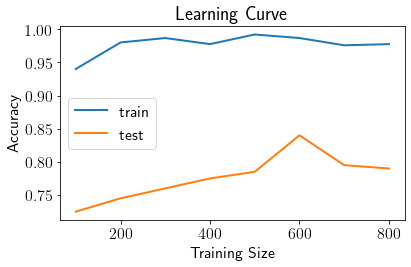

In [27]:
def learning_curve(X_train, X_test, y_train, y_test, model, step=100):
    """
    Calculate the performance of the model after a set of training data.
    """
    n_train = y_train.shape[0]
    sizes = list(range(step, n_train+1, step))
    metrics = ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1']
    results_df = pd.DataFrame(columns=metrics, index=sizes)
    
    for i, s in enumerate(sizes):
        model.fit(X_train[:s], y_train[:s])

        y_train_pred = model.predict(X_train[:s])
        results_df.at[s, 'train_accuracy'] = accuracy_score(y_train[:s], y_train_pred)
        results_df.at[s, 'train_f1'] = f1_score(y_train[:s], y_train_pred)
        
        y_test_pred  = model.predict(X_test)
        results_df.at[s, 'test_accuracy']  = accuracy_score(y_test, y_test_pred)
        results_df.at[s, 'test_f1']  = f1_score(y_test, y_test_pred)
        
    display(results_df)
    compare_lines(sizes, 'Training Size', 'Accuracy',
                  [results_df.train_accuracy, results_df.test_accuracy],
                  labels=['train','test'],title='Learning Curve')

clf = GradientBoostingClassifier(max_depth=7, max_features='auto', min_samples_leaf=20, random_state=101)
learning_curve(X_train, X_test, y_train, y_test, clf)

### 5.4 Comments

70% of the population is a good credit risk. Our model is better than guessing. The train accuracy is significantly higher than the test accuracy. We are overfitting. We could do better with more data to train on - the model is still learning.

## 6 Calculate fairness metrics on the model output

### 6.1 Make model predictions and check independence fairness metrics

- Pick the best model based on our grid cross validation
- Train on the training dataset
- Make predictions on the data set
- Create model_df -> model_ds and model_metric
- Calculate the fairness metrics on the model output for the full dataset

In [28]:
model_df = pd.concat([X, pd.Series(clf.predict(X), name='goodcredit')], axis=1)

model_ds = BinaryLabelDataset(df = model_df,
                              label_names = ['goodcredit'],
                              protected_attribute_names = ['male'])

model_metric = BinaryLabelDatasetMetric(model_ds,
                                        privileged_groups = privileged_groups,
                                        unprivileged_groups = unprivileged_groups)

outcomes_df.at['model', 'female'    ] = model_metric.base_rate(privileged=0)
outcomes_df.at['model', 'male'      ] = model_metric.base_rate(privileged=1)
outcomes_df.at['model', 'difference'] = model_metric.mean_difference()
outcomes_df.at['model', 'ratio'     ] = model_metric.disparate_impact()

display(outcomes_df)

,female,male,difference,ratio
data,0.648387,0.723188,-0.0748013,0.896567
model,0.683871,0.753623,-0.0697522,0.907444
train data,NaN,NaN,NaN,NaN
train model,NaN,NaN,NaN,NaN
test data,NaN,NaN,NaN,NaN
test model,NaN,NaN,NaN,NaN


In [29]:
# Quick check we did it right
probs = model_df[['male', 'goodcredit']].groupby('male').mean()
display(probs)
print('difference:', probs.goodcredit[0] - probs.goodcredit[1])
print('ratio:', probs.goodcredit[0] / probs.goodcredit[1])

,goodcredit
male,
0,0.683871
1,0.753623


difference: -0.06975222066386166
ratio: 0.9074441687344913


### 6.2 Comments

- The model acceptance rates are slightly higher than the data acceptance rates for both men and women
- The model fairness metrics differ slightly from the data fairness metrics.

### 6.3 Calculate consistency for the model output

In [30]:
consistency.at['model', 'original'] = model_metric.consistency()
consistency.at['model', 'ignore_protected'] = model_metric.consistency(ignore_protected=True)

display(consistency)

/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,original,ignore_protected
data,0.6814,0.6812
model,0.7066,0.7064
train data,NaN,NaN
train model,NaN,NaN
test data,NaN,NaN
test model,NaN,NaN


### 6.4 Calculate independence fairness metrics on our train set only

In [31]:
clf = GradientBoostingClassifier(max_depth=7, max_features='auto', min_samples_leaf=20, random_state=101)
clf.fit(X_train, y_train)

modelTr_df = pd.concat([X_train, pd.Series(clf.predict(X_train),
                                           name='goodcredit',
                                           index = X_train.index)], axis=1)
modelTr_ds = BinaryLabelDataset(df = modelTr_df,
                                label_names = ['goodcredit'],
                                protected_attribute_names = ['male'])

modelTr_metric = BinaryLabelDatasetMetric(modelTr_ds,
                                          privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups)

dataTr_ds = BinaryLabelDataset(df = pd.concat([X_train, y_train], axis=1),
                               label_names = ['goodcredit'],
                               protected_attribute_names = ['male'])

dataTr_metric = BinaryLabelDatasetMetric(dataTr_ds,
                                         privileged_groups = privileged_groups,
                                         unprivileged_groups = unprivileged_groups)

outcomes_df.at['train data', 'female'    ] = dataTr_metric.base_rate(privileged=0)
outcomes_df.at['train data', 'male'      ] = dataTr_metric.base_rate(privileged=1)
outcomes_df.at['train data', 'difference'] = dataTr_metric.mean_difference()
outcomes_df.at['train data', 'ratio'     ] = dataTr_metric.disparate_impact()

outcomes_df.at['train model', 'female'    ] = modelTr_metric.base_rate(privileged=0)
outcomes_df.at['train model', 'male'      ] = modelTr_metric.base_rate(privileged=1)
outcomes_df.at['train model', 'difference'] = modelTr_metric.mean_difference()
outcomes_df.at['train model', 'ratio'     ] = modelTr_metric.disparate_impact()

display(outcomes_df)

,female,male,difference,ratio
data,0.648387,0.723188,-0.0748013,0.896567
model,0.683871,0.753623,-0.0697522,0.907444
train data,0.658915,0.719557,-0.0606425,0.915723
train model,0.678295,0.728782,-0.0504877,0.930723
test data,NaN,NaN,NaN,NaN
test model,NaN,NaN,NaN,NaN


In [32]:
# Quick check we did it right
probs = pd.concat([X_train['male'], y_train], axis=1).groupby('male').mean()
display(probs)
print('difference:', probs.goodcredit[0] - probs.goodcredit[1])
print('ratio:', probs.goodcredit[0] / probs.goodcredit[1])

,goodcredit
male,
0,0.658915
1,0.719557


difference: -0.06064246688978525
ratio: 0.9157225203736831


In [33]:
# Quick check we did it right
probs = modelTr_df[['male', 'goodcredit']].groupby('male').mean()
display(probs)
print('difference:', probs.goodcredit[0] - probs.goodcredit[1])
print('ratio:', probs.goodcredit[0] / probs.goodcredit[1])

,goodcredit
male,
0,0.678295
1,0.728782


difference: -0.0504877141794674
ratio: 0.9307231871258954


### 6.5 Calculate consistency for the train set only

In [34]:
consistency.at['train data', 'original'] = dataTr_metric.consistency()
consistency.at['train data', 'ignore_protected'] = dataTr_metric.consistency(ignore_protected=True)

consistency.at['train model', 'original'] = modelTr_metric.consistency()
consistency.at['train model', 'ignore_protected'] = modelTr_metric.consistency(ignore_protected=True)

display(consistency)

/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarni

,original,ignore_protected
data,0.6814,0.68120
model,0.7066,0.70640
train data,0.6705,0.67025
train model,0.6885,0.68825
test data,NaN,NaN
test model,NaN,NaN


### 6.6 Calculate independence fairness metrics on our test set only

In [35]:
modelTs_df = pd.concat([X_test, pd.Series(clf.predict(X_test),
                                          name='goodcredit',
                                          index = X_test.index)], axis=1)
modelTs_ds = BinaryLabelDataset(df = modelTs_df,
                                label_names = ['goodcredit'],
                                protected_attribute_names = ['male'])

modelTs_metric = BinaryLabelDatasetMetric(modelTs_ds,
                                          privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups)

dataTs_ds = BinaryLabelDataset(df = pd.concat([X_test, y_test], axis=1),
                               label_names = ['goodcredit'],
                               protected_attribute_names = ['male'])

dataTs_metric = BinaryLabelDatasetMetric(dataTs_ds,
                                         privileged_groups = privileged_groups,
                                         unprivileged_groups = unprivileged_groups)

outcomes_df.at['test data', 'female'    ] = dataTs_metric.base_rate(privileged=0)
outcomes_df.at['test data', 'male'      ] = dataTs_metric.base_rate(privileged=1)
outcomes_df.at['test data', 'difference'] = dataTs_metric.mean_difference()
outcomes_df.at['test data', 'ratio'     ] = dataTs_metric.disparate_impact()

outcomes_df.at['test model', 'female'    ] = modelTs_metric.base_rate(privileged=0)
outcomes_df.at['test model', 'male'      ] = modelTs_metric.base_rate(privileged=1)
outcomes_df.at['test model', 'difference'] = modelTs_metric.mean_difference()
outcomes_df.at['test model', 'ratio'     ] = modelTs_metric.disparate_impact()

display(outcomes_df)

,female,male,difference,ratio
data,0.648387,0.723188,-0.0748013,0.896567
model,0.683871,0.753623,-0.0697522,0.907444
train data,0.658915,0.719557,-0.0606425,0.915723
train model,0.678295,0.728782,-0.0504877,0.930723
test data,0.596154,0.736486,-0.140333,0.809457
test model,0.711538,0.844595,-0.133056,0.842462


In [36]:
# Quick check we did it right
probs = pd.concat([X_test['male'], y_test], axis=1).groupby('male').mean()
display(probs)
print('difference:', probs.goodcredit[0] - probs.goodcredit[1])
print('ratio:', probs.goodcredit[0] / probs.goodcredit[1])

,goodcredit
male,
0,0.596154
1,0.736486


difference: -0.14033264033264037
ratio: 0.8094565984474241


In [37]:
# Quick check we did it right
probs = modelTs_df[['male', 'goodcredit']].groupby('male').mean()
display(probs)
print('difference:', probs.goodcredit[0] - probs.goodcredit[1])
print('ratio:', probs.goodcredit[0] / probs.goodcredit[1])

,goodcredit
male,
0,0.711538
1,0.844595


difference: -0.13305613305613306
ratio: 0.8424615384615385


### 6.7 Comments

The model fairness metrics differ slightly from the data fairness metrics.

### 6.8 Calculate consistency for the test set only

In [38]:
consistency.at['test data', 'original'] = dataTs_metric.consistency()
consistency.at['test data', 'ignore_protected'] = dataTs_metric.consistency(ignore_protected=True)

consistency.at['test model', 'original'] = modelTs_metric.consistency()
consistency.at['test model', 'ignore_protected'] = modelTs_metric.consistency(ignore_protected=True)

display(consistency)

/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/leenamurgai/anaconda3/envs/aif360lm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarni

,original,ignore_protected
data,0.6814,0.68120
model,0.7066,0.70640
train data,0.6705,0.67025
train model,0.6885,0.68825
test data,0.7040,0.70400
test model,0.7810,0.78100


### 6.9 Comments



### 6.10 Check error metrics (on test set)

In [39]:
clf_metric = ClassificationMetric(data_ds,
                                  model_ds,
                                  privileged_groups = privileged_groups,
                                  unprivileged_groups = unprivileged_groups)

clfTr_metric = ClassificationMetric(dataTr_ds,
                                    modelTr_ds,
                                    privileged_groups = privileged_groups,
                                    unprivileged_groups = unprivileged_groups)

clfTs_metric = ClassificationMetric(dataTs_ds,
                                    modelTs_ds,
                                    privileged_groups = privileged_groups,
                                    unprivileged_groups = unprivileged_groups)

errors_df = pd.DataFrame(columns=['female', 'male', 'difference', 'ratio'],
                         index=['ACC', 'ERR', 'FPR', 'FNR', 'FDR', 'FOR'])

errors_df.at['ACC', 'female'] = clfTs_metric.accuracy(privileged=False)
errors_df.at['ERR', 'female'] = clfTs_metric.error_rate(privileged=False)
errors_df.at['FPR', 'female'] = clfTs_metric.false_positive_rate(privileged=False)
errors_df.at['FNR', 'female'] = clfTs_metric.false_negative_rate(privileged=False)
errors_df.at['FDR', 'female'] = clfTs_metric.false_discovery_rate(privileged=False)
errors_df.at['FOR', 'female'] = clfTs_metric.false_omission_rate(privileged=False)

errors_df.at['ACC', 'male'] = clfTs_metric.accuracy(privileged=True)
errors_df.at['ERR', 'male'] = clfTs_metric.error_rate(privileged=True)
errors_df.at['FPR', 'male'] = clfTs_metric.false_positive_rate(privileged=True)
errors_df.at['FNR', 'male'] = clfTs_metric.false_negative_rate(privileged=True)
errors_df.at['FDR', 'male'] = clfTs_metric.false_discovery_rate(privileged=True)
errors_df.at['FOR', 'male'] = clfTs_metric.false_omission_rate(privileged=True)

errors_df.at['ACC', 'difference'] = errors_df.at['ACC', 'female'] - errors_df.at['ACC', 'male']
errors_df.at['ERR', 'difference'] = clfTs_metric.error_rate_difference()
errors_df.at['FPR', 'difference'] = clfTs_metric.false_positive_rate_difference()
errors_df.at['FNR', 'difference'] = clfTs_metric.false_negative_rate_difference()
errors_df.at['FDR', 'difference'] = clfTs_metric.false_discovery_rate_difference()
errors_df.at['FOR', 'difference'] = clfTs_metric.false_omission_rate_difference()

errors_df.at['ACC', 'ratio'] = errors_df.at['ACC', 'female'] / errors_df.at['ACC', 'male']
errors_df.at['ERR', 'ratio'] = clfTs_metric.error_rate_ratio()
errors_df.at['FPR', 'ratio'] = clfTs_metric.false_positive_rate_ratio()
errors_df.at['FNR', 'ratio'] = clfTs_metric.false_negative_rate_ratio()
errors_df.at['FDR', 'ratio'] = clfTs_metric.false_discovery_rate_ratio()
errors_df.at['FOR', 'ratio'] = clfTs_metric.false_omission_rate_ratio()

display(errors_df)

,female,male,difference,ratio
ACC,0.807692,0.783784,0.0239085,1.0305
ERR,0.192308,0.216216,-0.0239085,0.889423
FPR,0.380952,0.615385,-0.234432,0.619048
FNR,0.0645161,0.0733945,-0.00887837,0.879032
FDR,0.216216,0.192,0.0242162,1.12613
FOR,0.133333,0.347826,-0.214493,0.383333


### 6.5 Comments

- Error rates are higher for females

## 7 Randomised predictions

### 7.1 Exercise 1

Write a function which maps the model score to the probability of acceptance. The function should take a two thresholds, t1 < t2. The probability of acceptance should be zero if the score is less than t1, one if the score is greater than t2 and increase linearly from zero to one for model scores between the two thresholds.

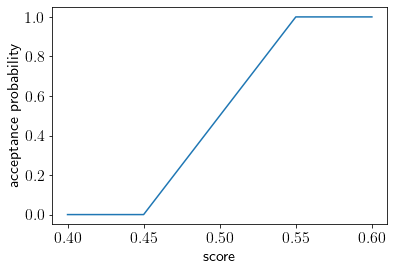

In [40]:
def accept_proability(score, t1=0.45, t2=0.55):
    if score<=t1: return 0
    if score>=t2: return 1
    return (score-t1)/(t2-t1)

# Check our function
probs = np.linspace(0.4, 0.6, num=21)
accept_probs = [accept_proability(p) for p in probs]
plt.xlabel('score')
plt.ylabel('acceptance probability')
ax = plt.plot(probs, accept_probs)

### 7.2 Exercise 2

Write a function that takes a probability value p and outputs the value one with probability p and zero with probability 1 − p.

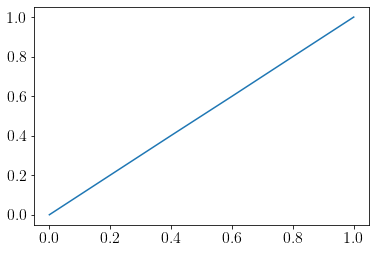

In [41]:
def predict(probability):
    return int(random.random()<probability)

# Check our function
probs = np.linspace(0, 1, num=6)
nrand = 1000000
rands = [sum([predict(p) for i in range(nrand)])/nrand for p in probs]
ax = plt.plot(probs, rands)

### 7.3 Exercise 3

Compose the functions above and use them to make randomised predictions from your model.

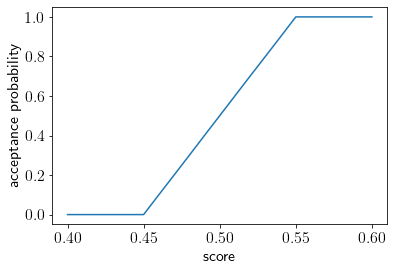

In [42]:
def model_prediction(model_score, t1=0.45, t2=0.55):
    return predict(accept_proability(model_score, t1,t2))

# Check our function
probs = np.linspace(0.4, 0.6, num=21)
rands = [sum([model_prediction(p) for i in range(nrand)])/nrand for p in probs]
plt.xlabel('score')
plt.ylabel('acceptance probability')
ax = plt.plot(probs, rands)

## 8 Inequality Indices

Functions in AIF360:

generalized entropy index
- `generalized_entropy_index`
- `between_group_generalized_entropy_index`
- `between_all_groups_generalized_entropy_index`

coefficient of variation
- `coefficient_of_variation`
- `between_group_coefficient_of_variation`
- `between_all_groups_coefficient_of_variation`

theil index
- `theil_index`
- `between_group_theil_index`
- `between_all_groups_theil_index`

Things we can look at:
- Index values for different benefit functions
  - Investigate behaviour of the indices for dummy binary benefits
  - 7 different benefit function in the table
  - Look at how the index changes as we increase the false positive benefit
  - Look at how the index changes as we increase the number of protected groups
  
### 8.1 Generalized Entropy Index Behaviour

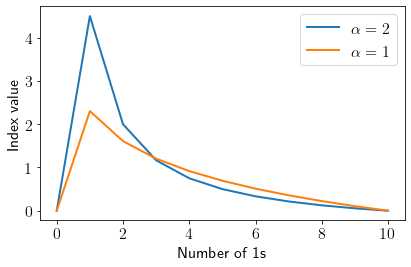

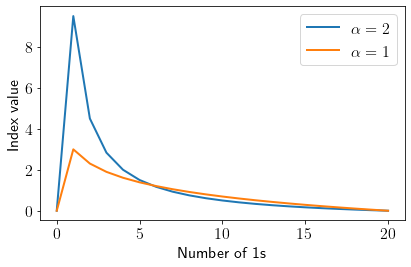

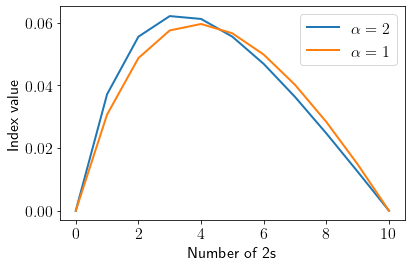

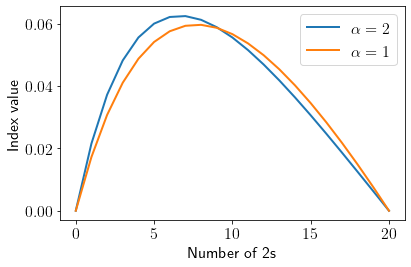

In [43]:
def compare_indices(base, n):
    b   = base*np.ones(n)
    gei = np.zeros(n+1)
    thi = np.zeros(n+1)
    #cov = np.zeros(n+1)
    for i in range(n):
        b[i] += 1
        gei[i+1] = clf_metric._generalized_entropy_index(b)
        thi[i+1] = clf_metric._generalized_entropy_index(b, alpha=1)
        #cov[i+1] = 2*math.sqrt(gei[i+1])
    compare_lines(np.array(range(n+1)),
                  x_label='Number of '+str(base+1)+'s', y_label='Index value',
                  lines=[gei, thi], labels=[r'$\alpha=2$',r'$\alpha=1$'],
                  title=None, filename='GEIbehave_b'+str(base)+'_n'+str(n))

compare_indices(0,10)
compare_indices(0,20)
compare_indices(1,10)
compare_indices(1,20)

In [44]:
# Generalized entropy index is scale invariant
b = np.array([1,0])
print(clf_metric._generalized_entropy_index(b))
b = np.array([10,0])
print(clf_metric._generalized_entropy_index(b))
b = np.array([10000000000000000000000000,2])
print(clf_metric._generalized_entropy_index(b))

0.5
0.5
0.5


### 8.2 Comments

- How you define your benefit function is important!
- Be careful choosing a base benefit of zero.
- Index is maximal when only one individual has a non-zero benefit.
- I_max = (n - 1) / 2

### 8.3 Generalized Entropy Index and the Between Group Component for Different Benefit Functions

In [45]:
# Some quick tests after adding the generic benefit function to AIF360

UNI_bf = {'TP':1, 'TN':1, 'FP':2, 'FN':0} # unified approach

print('generalized_entropy_index')
print(clf_metric.generalized_entropy_index())
print(clf_metric.generalized_entropy_index(benefit_function=UNI_bf))
print()
print('between_group_generalized_entropy_index')
print(clf_metric.between_group_generalized_entropy_index())
print(clf_metric.between_group_generalized_entropy_index(benefit_function=UNI_bf))
print()


privileged2_groups = [{'male':1, 'age>=30':1}]
unprivileged2_groups = [{'male':0}, {'age>=30':0}]

data2_ds = BinaryLabelDataset(df = data_df[['male', 'age>=30', 'goodcredit']],
                              label_names = ['goodcredit'],
                              protected_attribute_names = ['male', 'age>=30'])

clf = GradientBoostingClassifier(max_depth=7, max_features='auto', min_samples_leaf=20)
clf.fit(X, y)
model2_df = pd.concat([X[['male', 'age>=30']],
                       pd.Series(clf.predict(X), name='goodcredit')], axis=1)

model2_ds = BinaryLabelDataset(df = model2_df,
                               label_names = ['goodcredit'],
                               protected_attribute_names = ['male', 'age>=30'])

clf2_metric = ClassificationMetric(data2_ds,
                                   model2_ds,
                                   privileged_groups = privileged2_groups,
                                   unprivileged_groups = unprivileged2_groups)
print('between_all_groups_generalized_entropy_index')
print(clf2_metric.between_all_groups_generalized_entropy_index())
print(clf2_metric.between_all_groups_generalized_entropy_index(benefit_function=UNI_bf))

generalized_entropy_index
0.027687638964004512
0.027687638964004512

between_group_generalized_entropy_index
2.5600434486933165e-06
2.5600434486933165e-06

between_all_groups_generalized_entropy_index
3.0351488086868717e-05
3.0351488086868717e-05


In [46]:
data_bf  = {'TP':1, 'TN':0, 'FP':0, 'FN':1} # equal acceptance rate in data (independence in data)
model_bf = {'TP':1, 'TN':0, 'FP':1, 'FN':0} # equal acceptance rate in model independence in model)

ACC_bf = {'TP':1, 'TN':1, 'FP':0, 'FN':0} # equal accuracy
ERR_bf = {'TP':0, 'TN':0, 'FP':1, 'FN':1} # equal error rate (for testing only - not a valid benefit function)
FPR_bf = {        'TN':1, 'FP':0        } # equal false positive rate
FNR_bf = {'TP':1,                 'FN':0} # equal false negative rate
FDR_bf = {'TP':1,         'FP':0        } # equal false discovery rate
FOR_bf = {        'TN':1,         'FN':0} # equal false omission rate

gei_df = pd.DataFrame(columns=['gei_index', 'gei_group', 'gei_frac', 'th_index', 'th_group', 'th_frac'],
                        index=['data', 'model', 'ACC', 'ERR', 'FPR', 'FNR', 'FDR', 'FOR', 'UNI'])

for row in gei_df.index:
    gei_df.at[row, 'gei_index'] = clfTs_metric.generalized_entropy_index(benefit_function=eval(row+'_bf'))
    gei_df.at[row, 'gei_group'] = clfTs_metric.between_group_generalized_entropy_index(benefit_function=eval(row+'_bf'))
    gei_df.at[row, 'gei_frac'] = gei_df.gei_group[row] / gei_df.gei_index[row]
    gei_df.at[row, 'th_index'] = clfTs_metric.theil_index(benefit_function=eval(row+'_bf'))
    gei_df.at[row, 'th_group'] = clfTs_metric.between_group_theil_index(benefit_function=eval(row+'_bf'))
    gei_df.at[row, 'th_frac'] = gei_df.th_group[row] / gei_df.th_index[row]

gei_df = gei_df.rename(index={'data':'test data', 'model':'test model'})

display(gei_df)
display(errors_df)
display(outcomes_df)

comparison_df = pd.DataFrame()

,gei_index,gei_group,gei_frac,th_index,th_group,th_frac
test data,0.214286,0.00386631,0.0180428,0.356675,0.0040023,0.0112211
test model,0.117284,0.00259582,0.0221328,0.210721,0.00266935,0.0126677
ACC,0.132911,8.81102e-05,0.000662925,0.235722,8.76892e-05,0.000372002
ERR,1.88095,0.00124693,0.000662925,1.56065,0.00127084,0.000814303
FPR,0.571429,0.028706,0.0502355,0.76214,0.0276,0.0362138
FNR,0.0384615,7.88021e-06,0.000204885,0.074108,7.86627e-06,0.000106146
FDR,0.123077,8.02431e-05,0.000651975,0.220062,8.06874e-05,0.000366658
FOR,0.178571,0.0101227,0.0566874,0.305382,0.00995411,0.0325956
UNI,0.08031,4.13404e-06,5.1476e-05,0.0954662,4.12972e-06,4.32585e-05


,female,male,difference,ratio
ACC,0.807692,0.783784,0.0239085,1.0305
ERR,0.192308,0.216216,-0.0239085,0.889423
FPR,0.380952,0.615385,-0.234432,0.619048
FNR,0.0645161,0.0733945,-0.00887837,0.879032
FDR,0.216216,0.192,0.0242162,1.12613
FOR,0.133333,0.347826,-0.214493,0.383333


,female,male,difference,ratio
data,0.648387,0.723188,-0.0748013,0.896567
model,0.683871,0.753623,-0.0697522,0.907444
train data,0.658915,0.719557,-0.0606425,0.915723
train model,0.678295,0.728782,-0.0504877,0.930723
test data,0.596154,0.736486,-0.140333,0.809457
test model,0.711538,0.844595,-0.133056,0.842462


In [62]:
group_df = pd.concat([outcomes_df.loc[['test data', 'test model']],errors_df])
index_df = gei_df[['gei_group', 'gei_frac']].loc[['test data', 'test model', 'ACC', 'ERR', 'FPR', 'FNR', 'FDR', 'FOR']]
compare_df = pd.concat([group_df, index_df], axis=1)

display(compare_df)

compare_df['ratio_min'] = 1/compare_df.ratio
compare_df['ratio_min'] = compare_df[['ratio', 'ratio_min']].min(axis=1)
compare_df['diff_abs'] = np.abs(compare_df['difference'])

cols = ['diff_abs', 'ratio_min', 'gei_group', 'gei_frac']
for col in cols:
    print(col, '\t', list(compare_df[col].sort_values().index))

display(compare_df[cols])

,female,male,difference,ratio,gei_group,gei_frac
test data,0.596154,0.736486,-0.140333,0.809457,0.00386631,0.0180428
test model,0.711538,0.844595,-0.133056,0.842462,0.00259582,0.0221328
ACC,0.807692,0.783784,0.0239085,1.0305,8.81102e-05,0.000662925
ERR,0.192308,0.216216,-0.0239085,0.889423,0.00124693,0.000662925
FPR,0.380952,0.615385,-0.234432,0.619048,0.028706,0.0502355
FNR,0.0645161,0.0733945,-0.00887837,0.879032,7.88021e-06,0.000204885
FDR,0.216216,0.192,0.0242162,1.12613,8.02431e-05,0.000651975
FOR,0.133333,0.347826,-0.214493,0.383333,0.0101227,0.0566874


diff_abs 	 ['FNR', 'ACC', 'ERR', 'FDR', 'test model', 'test data', 'FOR', 'FPR']
ratio_min 	 ['FOR', 'FPR', 'test data', 'test model', 'FNR', 'FDR', 'ERR', 'ACC']
gei_group 	 ['FNR', 'FDR', 'ACC', 'ERR', 'test model', 'test data', 'FOR', 'FPR']
gei_frac 	 ['FNR', 'FDR', 'ACC', 'ERR', 'test data', 'test model', 'FPR', 'FOR']


,diff_abs,ratio_min,gei_group,gei_frac
test data,0.140333,0.809457,0.00386631,0.0180428
test model,0.133056,0.842462,0.00259582,0.0221328
ACC,0.0239085,0.970399,8.81102e-05,0.000662925
ERR,0.0239085,0.889423,0.00124693,0.000662925
FPR,0.234432,0.619048,0.028706,0.0502355
FNR,0.00887837,0.879032,7.88021e-06,0.000204885
FDR,0.0242162,0.888000,8.02431e-05,0.000651975
FOR,0.214493,0.383333,0.0101227,0.0566874


### 8.2 Comments

- The between group componant of the generalized entropy index is very small part of the index value
- When we compare the between group component of the generalized entropy index with the error rates for the privileged and unprivileged groups the relative fairness metrics do not align in terms of order, because the generalized entropy index accounts for the relative sizes of the groups.
- The between group component as a proportion of the index is the same for ERR and ACC, i.e. it stays the same if we switch zeros to ones and ones to zeros.

### 8.3 Understanding the between group component of the generalised enropy index

- For a partition of the population into g groups, the between group component is effectively the value of the inequality index for g individuals (one for each group), each of which has the mean benefit for their group but, the contribution of each individual is weighted by the prevalence of that group. See the computations below.
- The computation below verifies the expression in the book which describes the between-group component of the index as a function of the mean benefits.

In [48]:
print('\t','male\t','female' )
n_male = np.sum(data_df['male'][data_df['male']==1])
n_female = len(data_df)-n_male
print('data_df\t', n_male, '\t', n_female)

nTr_male = np.sum(X_train['male'][X_train['male']==1])
nTr_female = len(X_train)-nTr_male
print('X_train\t', nTr_male, '\t', nTr_female)

nTs_male = np.sum(X_test['male'][X_test['male']==1])
nTs_female = len(X_test)-nTs_male
print('X_test\t', nTs_male, '\t', nTs_female)
print()

print('Between group component gei data outcome')
print(clf_metric._generalized_entropy_index(np.array(n_female*[outcomes_df.female['data']] +
                                                     n_male*[outcomes_df.male['data']])))
print(clf_metric.between_group_generalized_entropy_index(benefit_function=data_bf))
print()

print('Between group component gei model outcome')
print(clf_metric._generalized_entropy_index(np.array(n_female*[outcomes_df.female['model']] +
                                                     n_male*[outcomes_df.male['model']])))
print(clf_metric.between_group_generalized_entropy_index(benefit_function=model_bf))
print()

print('Between group component gei test data - benefit based on accurate predictions')
print(clfTs_metric._generalized_entropy_index(np.array(nTs_female*[errors_df.female['ACC']] +
                                                       nTs_male*[errors_df.male['ACC']])))
print(clfTs_metric.between_group_generalized_entropy_index(benefit_function=ACC_bf))

	 male	 female
data_df	 690 	 310
X_train	 542 	 258
X_test	 148 	 52

Between group component gei data outcome
0.0012212458615985166
0.0012212458615985166

Between group component gei model outcome
0.0009711240372819141
0.0009711240372819141

Between group component gei test data - benefit based on accurate predictions
8.811024673843981e-05
8.811024673843981e-05


In [49]:
print('\t','1\t','0' )
n_1 = np.sum(data_df['goodcredit'][data_df['goodcredit']==1])
n_0 = len(data_df)-n_1
print('data_df\t', n_1, '\t', n_0)

print()
print(clf_metric.between_group_generalized_entropy_index(benefit_function=data_bf)/
      clf_metric.generalized_entropy_index(benefit_function=data_bf))
print(n_female*n_male*(outcomes_df.male['data']-outcomes_df.female['data'])**2/n_1/n_0)

	 1	 0
data_df	 700 	 300

0.005699147354126413
0.0056991473541263046


### 8.4 Generalized Entropy Index as we Increase the FP benefit

The benefit function that is studied in [A Unified Approach to Quantifying Algorithmic Unfairness: Measuring Individual & Group Unfairness via Inequality Indices](https://arxiv.org/abs/1807.00787) is shown below.

**Benefit Function:**
```
           |       y       |
           |   1   |   0   |
| y_pred |1| TPB=1 | FPB=2 |
|        |0| FNB=0 | TNB=1 |
```

Here we are interested in looking at how the generalised entropy index and it's between group componant change for our model as we increase the false positive benefit.

,gei,w_group,b_group,b_frac
0,0.132911,0.132823,8.81102e-05,0.000662925
1,0.0263158,0.0262899,2.59155e-05,0.00098479
2,0.08031,0.0803059,4.13404e-06,5.1476e-05
3,0.191301,0.191301,6.44492e-08,3.36899e-07
4,0.319111,0.319107,4.11754e-06,1.29032e-05
5,0.447352,0.44734,1.18831e-05,2.65631e-05
6,0.569388,0.569367,2.12143e-05,3.72581e-05
7,0.682807,0.682776,3.10303e-05,4.54452e-05
8,0.787078,0.787037,4.07804e-05,5.18125e-05
9,0.882493,0.882443,5.01889e-05,5.68717e-05


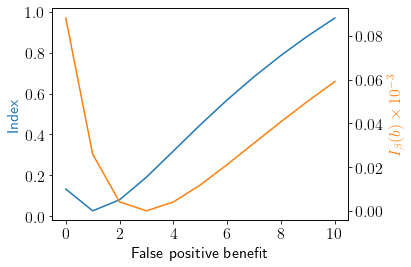

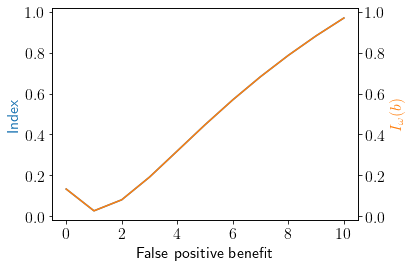

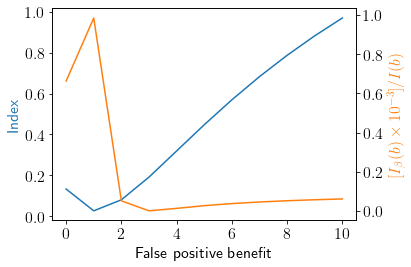

In [60]:
def double_axes_plot(x, y1, y2, x_label, y1_label, y2_label, title=None, filename=None):
    """
    Plot training and test values as a function of x.
    """
    fig, ax = plt.subplots()
    l1 = ax.plot(x, y1, color="#1f77b4", label=y1_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y1_label, color='#1f77b4')
    ax2=ax.twinx()
    l2 = ax2.plot(x,  y2, color="#ff7f0e", label=y2_label)
    ax2.set_ylabel(y2_label, color='#ff7f0e')
    plt.title(title)
    #lns = l1+l2
    #labs = [y1_label, y2_label]
    #ax.legend(lns, labs)
    plt.tight_layout()
    if filename:
        plt.savefig('mbml_figures/Fig_'+filename+'.png')
    plt.show()

def increasing_FPB():
    FPBs = list(range(11))
    results_df = pd.DataFrame(columns=['gei', 'w_group', 'b_group', 'b_frac'], index=FPBs)
    for b in FPBs:
        bf = {'TP':1, 'TN':1, 'FP':b, 'FN':0}
        results_df.at[b,'gei'] = clfTs_metric.generalized_entropy_index(benefit_function=bf)
        results_df.at[b,'b_group'] = clfTs_metric.between_group_generalized_entropy_index(benefit_function=bf)
        results_df.at[b,'w_group'] = results_df.at[b,'gei'] - results_df.at[b,'b_group']
        results_df.at[b,'b_frac'] = results_df.at[b,'b_group'] / results_df.at[b,'gei']
    display(results_df)
    double_axes_plot(FPBs, results_df.gei, 1000*results_df.b_group,
                     'False positive benefit', 'Index', r'$I_{\beta}(b)\times 10^{-3}$',
                     filename='UnifiedVaryFPB_bgc')
    double_axes_plot(FPBs, results_df.gei, results_df.w_group,
                     'False positive benefit', 'Index', r'$I_{\omega}(b)$',
                     filename='UnifiedVaryFPB_wgc')
    double_axes_plot(FPBs, results_df.gei, 1000*results_df.b_frac,
                     'False positive benefit', 'Index', r'$[I_{\beta}(b)\times 10^{-3}]/I(b)$',
                     filename='UnifiedVaryFPB_bgf')
increasing_FPB()

# Appendices

## A Code Testing

### A.1 aif360.sklearn.metrics

In [51]:
import numpy as np
import pytest
from numpy.testing import assert_almost_equal
from sklearn.linear_model import LogisticRegression

from aif360.datasets import AdultDataset
from aif360.sklearn.datasets import fetch_adult
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import generalized_entropy_error
from aif360.sklearn.metrics import  between_group_generalized_entropy_error


X, y, sample_weight = fetch_adult(numeric_only=True)
lr = LogisticRegression(solver='liblinear').fit(X, y, sample_weight=sample_weight)
y_pred = lr.predict(X)
y_proba = lr.predict_proba(X)[:, 1]
adult = AdultDataset(instance_weights_name='fnlwgt', categorical_features=[],
        features_to_keep=['age', 'education-num', 'capital-gain',
                          'capital-loss', 'hours-per-week'],
        features_to_drop=[])
adult_pred = adult.copy()
adult_pred.labels = y_pred
adult_pred.scores = y_proba
cm = ClassificationMetric(adult, adult_pred,
                          unprivileged_groups=[{'sex': 0}],
                          privileged_groups=[{'sex': 1}])

In [52]:
#test_generalized_entropy_index
"""Tests that the old and new generalized_entropy_index matches exactly."""
print(generalized_entropy_error(y, y_pred))

0.10465559127990456


In [53]:
print('binary_confusion_matrix')
cmcm = cm.binary_confusion_matrix()
print(cmcm)
print()
print('instance_weights')
print(cm.dataset.instance_weights)

binary_confusion_matrix
{'TP': 886661524.0, 'FP': 312487131.0, 'TN': 6748432926.0, 'FN': 1315994081.0}

instance_weights
[226802.  89814. 336951. ... 151910. 201490. 287927.]


In [54]:
print(sum([v for k, v in cmcm.items()]))
print(np.sum(sample_weight))
print(np.sum(cm.dataset.instance_weights))

9263575662.0
9263575662.0
9263575662.0


### A.2 aif360.metrics

In [55]:
import numpy as np
import pandas as pd
import scipy.stats as ss

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

data = np.array([[0, 1],
                 [0, 0],
                 [1, 0],
                 [1, 1],
                 [1, 0],
                 [1, 0],
                 [2, 1],
                 [2, 0],
                 [2, 1],
                 [2, 1]])
pred = data.copy()
pred[[3, 9], -1] = 0
pred[[4, 5], -1] = 1
df = pd.DataFrame(data, columns=['feat', 'label'])
df2 = pd.DataFrame(pred, columns=['feat', 'label'])
bld = BinaryLabelDataset(df=df, label_names=['label'],
    protected_attribute_names=['feat'])
bld2 = BinaryLabelDataset(df=df2, label_names=['label'],
    protected_attribute_names=['feat'])
cm = ClassificationMetric(bld, bld2)
fpr_bf = {        'TN':1, 'FP':0        }

print('between_all_groups_generalized_entropy_index(benefit_function=fpr_bf)')
print(cm.between_all_groups_generalized_entropy_index(benefit_function=fpr_bf))

between_all_groups_generalized_entropy_index(benefit_function=fpr_bf)
0.14814814814814806


In [56]:
from itertools import product
from aif360.metrics import utils

all_values = list(map(np.concatenate, zip(cm.dataset.privileged_protected_attributes,
                                          cm.dataset.unprivileged_protected_attributes)))
groups = [[dict(zip(cm.dataset.protected_attribute_names, vals))] for vals in product(*all_values)]
print(groups)
for group in groups:
    true_group = utils.compute_boolean_conditioning_vector(
        cm.dataset.protected_attributes,
        cm.dataset.protected_attribute_names,
        condition=group)
    print(true_group)
    num_in_group = np.sum(true_group)
    confusion_matrix = utils.compute_num_TF_PN(
                cm.dataset.protected_attributes[true_group],
                cm.dataset.labels[true_group],
                cm.classified_dataset.labels[true_group],
                cm.dataset.instance_weights[true_group],
                cm.dataset.protected_attribute_names,
                cm.dataset.favorable_label, cm.dataset.unfavorable_label,
                condition=group)
    print(confusion_matrix)
    group_mean_benefit = np.mean(cm._get_benefits(confusion_matrix, fpr_bf))
    new_b = num_in_group*[group_mean_benefit]
    #b = b + new_b
    print(group_mean_benefit)
    print(new_b)
    #print(b)
    print()

[[{'feat': 2.0}], [{'feat': 0.0}], [{'feat': 1.0}]]
[False False False False False False  True  True  True  True]
{'TP': 2.0, 'FP': 0.0, 'TN': 1.0, 'FN': 1.0}
1.0
[1.0, 1.0, 1.0, 1.0]

[ True  True False False False False False False False False]
{'TP': 1.0, 'FP': 0.0, 'TN': 1.0, 'FN': 0.0}
1.0
[1.0, 1.0]

[False False  True  True  True  True False False False False]
{'TP': 0.0, 'FP': 2.0, 'TN': 1.0, 'FN': 1.0}
0.3333333333333333
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]



In [57]:
data = np.array([[0, 0, 1],
                 [0, 1, 0],
                 [1, 1, 0],
                 [1, 1, 1],
                 [1, 0, 0],
                 [1, 0, 0]])
pred = data.copy()
pred[[0, 3], -1] = 0
pred[[4, 5], -1] = 1
df = pd.DataFrame(data, columns=['feat', 'feat2', 'label'])
df2 = pd.DataFrame(pred, columns=['feat', 'feat2', 'label'])
bld = BinaryLabelDataset(df=df, label_names=['label'],
    protected_attribute_names=['feat', 'feat2'])
bld2 = BinaryLabelDataset(df=df2, label_names=['label'],
    protected_attribute_names=['feat', 'feat2'])
cm = ClassificationMetric(bld, bld2, unprivileged_groups=[{'feat': 0}],
    privileged_groups=[{'feat': 1}])

print(cm.between_group_generalized_entropy_index(benefit_function=fpr_bf))

0.16666666666666696


In [58]:
from itertools import product
from aif360.metrics import utils

all_values = list(map(np.concatenate, zip(cm.dataset.privileged_protected_attributes,
                                          cm.dataset.unprivileged_protected_attributes)))
groups = [cm._to_condition(False), cm._to_condition(True)]
print(groups)
b=[]
for group in groups:
    true_group = utils.compute_boolean_conditioning_vector(
        cm.dataset.protected_attributes,
        cm.dataset.protected_attribute_names,
        condition=group)
    print(true_group)
    num_in_group = np.sum(true_group)
    confusion_matrix = utils.compute_num_TF_PN(
                cm.dataset.protected_attributes[true_group],
                cm.dataset.labels[true_group],
                cm.classified_dataset.labels[true_group],
                cm.dataset.instance_weights[true_group],
                cm.dataset.protected_attribute_names,
                cm.dataset.favorable_label, cm.dataset.unfavorable_label,
                condition=group)
    print(confusion_matrix)
    group_benefits = cm._get_benefits(confusion_matrix, fpr_bf)
    group_mean_benefit = np.mean(group_benefits)
    new_b = len(group_benefits)*[group_mean_benefit]
    b = b + new_b
    print()

[[{'feat': 0}], [{'feat': 1}]]
[ True  True False False False False]
{'TP': 0.0, 'FP': 0.0, 'TN': 1.0, 'FN': 1.0}

[False False  True  True  True  True]
{'TP': 0.0, 'FP': 2.0, 'TN': 1.0, 'FN': 1.0}



### A.3 Consistency score - expose distance metric and ability to ignore protected features

In [59]:
from sklearn.neighbors import NearestNeighbors

def my_dist(x1, x2):
    return np.sqrt(np.sum((x1-x2)*(x1-x2)))
    #return np.sum(weights*(x1-x2)*(x1-x2))

clfNN = NearestNeighbors(n_neighbors=2, metric=my_dist)
clfNN.fit(X_train)
print('distances\tindices')
display(clfNN.kneighbors(X_train[:3]))
clfNN.kneighbors(X_train[:3])[1].shape

distances	indices


(array([[0.        , 7.41619849],
        [0.        , 6.63324958],
        [0.        , 8.88819442]]),
 array([[  0, 679],
        [  1, 299],
        [  2, 165]]))

(3, 2)